In [1]:
using LinearAlgebra
using FFTW
using Random
using CairoMakie

<font size="12">Spinor Structure</font>

In [2]:
function v_sigma(S, M, k, sigma)
    kx = k[1]
    ky = k[2]
    return sqrt(factorial(2*S) / factorial(S - sigma) / factorial(S + sigma)) * (kx - im*ky)^(S + sigma) * M^(S - sigma) / 
    (norm(k)^2 + M^2)^S
end

v_sigma (generic function with 1 method)

In [3]:
function spinor(S, M, k)
    vec = Array{ComplexF64}(undef, Int(2*S) + 1)
    for sigma in -S:S
        vec[Int(S + sigma) + 1] = v_sigma(S, M, k, sigma)
    end
    return vec
end

spinor (generic function with 1 method)

<font size="12">Form Factors</font>

In [4]:
a = 1 # lattice constant

1

In [5]:
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
G3 = -G1 - G2

K1 = (2/3) * G1 + (1/3) * G2
K3 = K1 - G1
K5 = K1 + G3

K2 = (1/3) * G1 + (2/3) * G2
K4 = K2 + G3
K6 = K2 - G2

Kpts = [K1, K2, K3, K4, K5, K6]

6-element Vector{Vector{Float64}}:
 [4.1887902047863905, 0.0]
 [2.0943951023931953, 3.6275987284684357]
 [-2.0943951023931957, 3.6275987284684357]
 [-4.188790204786391, 0.0]
 [-2.0943951023931957, -3.6275987284684357]
 [2.0943951023931953, -3.6275987284684357]

In [6]:
function Lambda(S, M, kappa_m, kappa_n)
    return dot(spinor(S, M, kappa_m), spinor(S, M, kappa_n))
end

Lambda (generic function with 1 method)

In [7]:
# Explicit form factor to check against spinor structure
function Lambda_v2(S, M, k1, k2)
    kx1, ky1 = k1
    kx2, ky2 = k2
    cross = kx1*ky2 - ky1*kx2
    return (M^2 + dot(k1, k2) - im*cross)^(2*S) / (M^2 + norm(k1)^2)^S / (M^2 + norm(k2)^2)^S
end

Lambda_v2 (generic function with 1 method)

<font size="12">Energy</font>

In [8]:
function E_hartree(S, M, C0, k_points)
    return (2/3) * real(exp(C0*(2*pi*im/3)) * Lambda(S, M, k_points[1], k_points[3]) * Lambda(S, M, k_points[4], k_points[6]))
end

E_hartree (generic function with 1 method)

In [9]:
function E_fock(S, M, C0, k_points)
    return (-2/3) * real(exp(C0*(-2*pi*im/3)) * Lambda(S, M, k_points[1], k_points[2]) * Lambda(S, M, k_points[4], k_points[5]))
end

E_fock (generic function with 1 method)

In [10]:
function E_tot(S, M, C0, k_points, Vg1, Vk1)
    return Vg1 * E_hartree(S, M, C0, k_points) + Vk1 * E_fock(S, M, C0, k_points)
end

E_tot (generic function with 1 method)

In [11]:
Vg = 1
Vk = 1/sqrt(3)
S = 10.5
m = 1

1

In [42]:
samps = 1000
v_list = range(0, 500, samps)

0.0:0.5005005005005005:500.0

In [43]:
# energies (C0, samples)
energies = Array{Float64}(undef, 3, samps)
for c in 0:2
    for k in 1:samps
        v = v_list[k]
        M = m*v/2
        energies[c + 1, k] = E_tot(S, M, c, Kpts, Vg, Vk)
    end
end

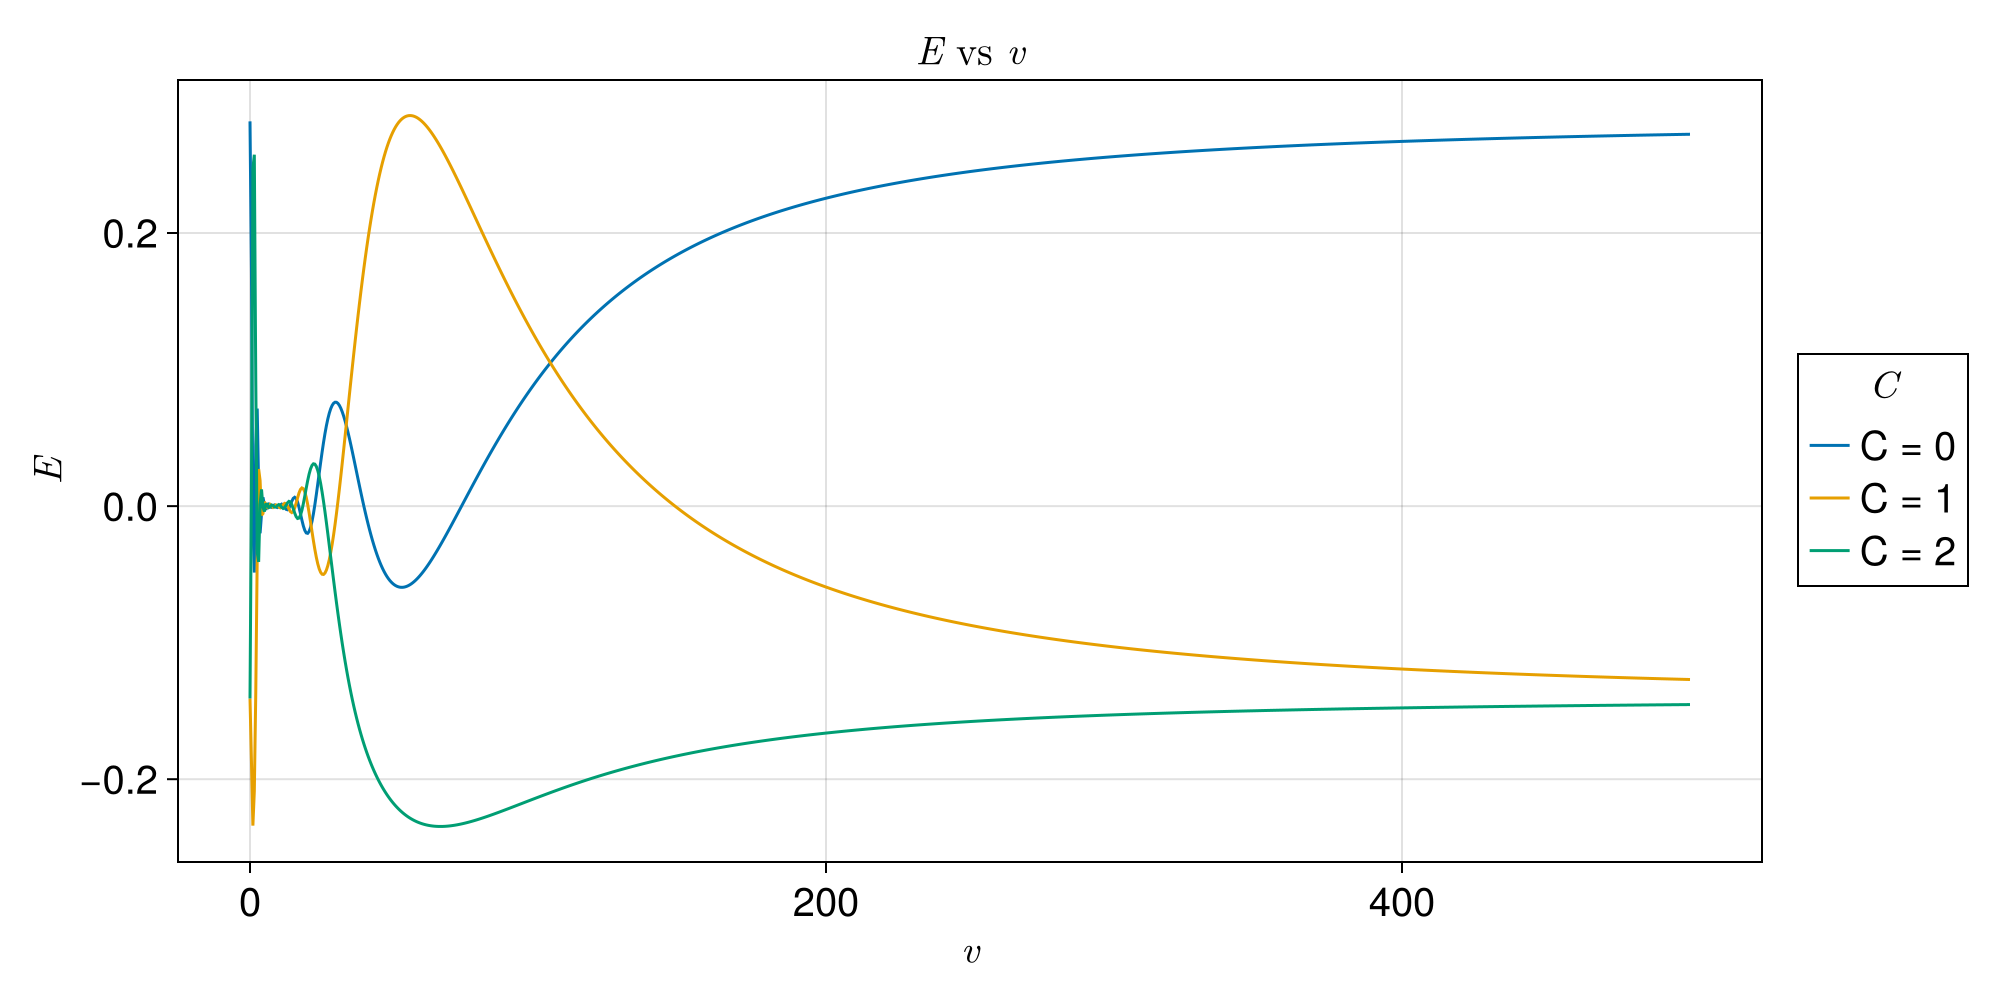

In [44]:
P = Figure(size=(1000, 500), fontsize=20)
ax = Axis(P[1, 1], 
title = L"E \ \text{vs} \ v", 
xlabel = L"v", ylabel = L"E")
for i in 1:3
    lines!(ax, v_list, energies[i, :], 
    label = "C = "*string(mod(i - 1, 3)))
end
P[1, 2] = Legend(P, ax, L"C", 
framevisible = true)
P

<font size="12">Berry Curvature</font>

In [15]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(S, M, x1, y1, x2, y2)
    ev1 = spinor(S, M, [x1, y1])
    ev2 = spinor(S, M, [x2, y2])
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [16]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(S, M, x1, y1, x2, y2, x3, y3, x4, y4)
    big_theta = theta(S, M, x2, y2, x1, y1) *
        theta(S, M, x3, y3, x2, y2) * theta(S, M, x4, y4, x3, y3) * 
    theta(S, M, x1, y1, x4, y4)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [17]:
# Berry curvature
function berry_curvature(points, n, S, M)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux(S, M, x1, y1, x2, y2, x3, y3, x4, y4)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 1 method)

In [18]:
function berry_curvature_v2(S, M, k)
    return (4*S*M^2)/(norm(k)^2 + M^2)^2
end

berry_curvature_v2 (generic function with 1 method)

In [19]:
# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, n, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, n, n, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, n)
    for i in 1:n
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, n, ky_pts[i])
    end
    return grid
end

k_zone (generic function with 1 method)

In [20]:
# parameters
pd = 40
rad = 1
# explore a small region around K point
k_grid = k_zone([0, 0], pd, rad)

40×40×2 Array{Float64, 3}:
[:, :, 1] =
 -0.5       -0.5       -0.5       …  -0.5       -0.5       -0.5
 -0.474359  -0.474359  -0.474359     -0.474359  -0.474359  -0.474359
 -0.448718  -0.448718  -0.448718     -0.448718  -0.448718  -0.448718
 -0.423077  -0.423077  -0.423077     -0.423077  -0.423077  -0.423077
 -0.397436  -0.397436  -0.397436     -0.397436  -0.397436  -0.397436
 -0.371795  -0.371795  -0.371795  …  -0.371795  -0.371795  -0.371795
 -0.346154  -0.346154  -0.346154     -0.346154  -0.346154  -0.346154
 -0.320513  -0.320513  -0.320513     -0.320513  -0.320513  -0.320513
 -0.294872  -0.294872  -0.294872     -0.294872  -0.294872  -0.294872
 -0.269231  -0.269231  -0.269231     -0.269231  -0.269231  -0.269231
 -0.24359   -0.24359   -0.24359   …  -0.24359   -0.24359   -0.24359
 -0.217949  -0.217949  -0.217949     -0.217949  -0.217949  -0.217949
 -0.192308  -0.192308  -0.192308     -0.192308  -0.192308  -0.192308
  ⋮                               ⋱                        
  0.217949

In [37]:
# Get berry curvature for all bands
M = 1
flux_list, kx_avg_list, ky_avg_list = berry_curvature(k_grid, pd, S, M)
true_fluxes = Array{Float64}(undef, (pd - 1)^2)
for i in 1:(pd-1)^2
    true_fluxes[i] = berry_curvature_v2(S, M, [kx_avg_list[i], ky_avg_list[i]])
end

In [38]:
computed_cn = sum(flux_list) * (pd - 1)^2 / (2 * pi)
@show computed_cn
true_cn = sum(true_fluxes) / (2 * pi)
@show true_cn

computed_cn = -7649.43607999706
true_cn = 7649.436136106872


7649.436136106872